Import necessary libraries

In [47]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pickle
import random

We will read in a dataset obtained from Kaggle: https://www.kaggle.com/datasets/thedevastator/cancer-patients-and-air-pollution-a-new-link?resource=download
The data was taken from a study that was published in the journal Nature Medicine, that documented information on 462,000 people from China over the span of 6 years.  It contains info from 1000 people on their surrounding environment/air pollution levels, various demographic factors, habits, existing health conditions, symptoms, and level of lung cancer.  The following fields from the dataset will be kept for our analysis: index, age, gender, alcohol use, smoking, shortness of breath, fatigue, and chronic lung disease.  
We will create an additional variable - LC_Level_numeric, which will specify whether or not the individual has lung cancer, and will be set to 1 for every instance in this dataset, since this data is specific to individuals with lung cancer.

In [48]:
#Read first data file, create needed columns, filter on specific columns
lc_data = pd.read_csv("cancer patient data sets.csv")
lc_data['LC_Level_numeric'] = 1
lc_data_small = lc_data[['index','Age','Gender','Alcohol use','Smoking','Shortness of Breath','Fatigue','chronic Lung Disease','Swallowing Difficulty','LC_Level_numeric']]


We will now read in a second dataset obtained from Kaggle: https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer?resource=download
The data was taken from an online lung cancer prediction system.  It contains info from 309 people on their demographicss, habits, existing health conditions, symptoms, and indicates whether or not they have lung cancer.  The following fields will be kept for our analysis: AGE, GENDER, SMOKING, CHRONIC DISEASE, FATIGUE, ALCOHOL CONSUMING, SHORTNESS OF BREATH, SWALLOWING DIFFICULTY, and LUNG CANCER.
Ultimately, we plan to merge this dataset together with the first dataset, so the columns of this dataset will need to be updated accordingly.  First, we create an index variable starting at 1000 for the first record, which was one more than the final index number in the first dataset.  Next we will create a new gender variable switching M and F for male and female to 1 and 2 respectively, which matches the formatting of the first dataset.  Next, many of the variables from the first dataset are respresented with a number from 1-9 to specify the level.  In this dataset, many of the variables have a value of either 1 for No or 2 for Yes.  We are creating new versions of these variables with updated logic that keeps the 1 values unchanged, but changes the 2 values to 6 - a moderate level, according to the other dataset's scaling.  We are creating a LC_Level_Numeric variable which gives a value of 0 for NO LUNG_CANCER and 1 for YES LUNG_CANCER.  Finally, we rename our variables appropriately and keep only the ones we need and produce our final dataset with the following columns: index, age, gender, alcohol use, smoking, shortness of breath, fatigue, chronic lung disease, and LC_Level_numeric.

In [49]:
#Read second data file, create needed columns, filter on specific columns
lc_data_2 = pd.read_csv("survey lung cancer.csv")
lc_data_2['index'] = range(1000, 1000+len(lc_data_2))
lc_data_2['Gender_2'] = np.where(lc_data_2['GENDER'] == 'M', 1, 2)
lc_data_2['Smoking_2'] = np.where(lc_data_2['SMOKING'] == 1, 1, 6)
lc_data_2['chronic Lung Disease'] = np.where(lc_data_2['CHRONIC DISEASE'] == 1, 1, 6)
lc_data_2['Fatigue'] = np.where(lc_data_2['FATIGUE '] == 1, 1, 6)
lc_data_2['Alcohol use'] = np.where(lc_data_2['ALCOHOL CONSUMING'] == 1, 1, 6)
lc_data_2['Shortness of Breath 2'] = np.where(lc_data_2['SHORTNESS OF BREATH'] == 1, 1, 6)
lc_data_2['Swallowing Difficulty 2'] = np.where(lc_data_2['SWALLOWING DIFFICULTY'] == 1, 1, 6)
lc_data_2['LC_Level_numeric'] = np.where(lc_data_2['LUNG_CANCER'] == 'NO', 0, 1)
lc_data_2_small = lc_data_2[['index','AGE','Gender_2','Smoking_2','chronic Lung Disease','Fatigue','Alcohol use','Shortness of Breath 2','Swallowing Difficulty 2','LC_Level_numeric']].copy()
lc_data_2_small.rename(columns={'Gender_2':'Gender','AGE':'Age','Smoking_2':'Smoking','Shortness of Breath 2':'Shortness of Breath','Swallowing Difficulty 2':'Swallowing Difficulty'},inplace=True)


Next, we will merge the two dataframes into one dataframe, lc_data_merge.  Taking the log of the Age variable will scale it down to fit the scaling of the rest of the variables.  Taking the log of the Shortness of Breath and Fatigue variables will help combat their skewedness.  Examine the below summary statistics chart.  

In [50]:
#merge dataframes
lc_data_merge = lc_data_small.merge(lc_data_2_small,how='outer',on=['index','Gender','Age','Smoking','chronic Lung Disease','Fatigue','Alcohol use','Shortness of Breath','Swallowing Difficulty','LC_Level_numeric'])
#Take log of variables
lc_data_merge['Age log'] = np.log(lc_data_merge['Age'])
lc_data_merge['Shortness of Breath log'] = np.log(lc_data_merge['Shortness of Breath'])
lc_data_merge['Fatigue log'] = np.log(lc_data_merge['Fatigue'])
lc_data_merge.describe().T

,count,mean,std,min,25%,50%,75%,max
index,1309.0,654.000000,378.020061,0.000000,327.000000,654.000000,981.000000,1308.000000
Age,1309.0,43.193277,15.598069,14.000000,32.000000,39.000000,56.000000,87.000000
Gender,1309.0,1.419404,0.493650,1.000000,1.000000,1.000000,2.000000,2.000000
Alcohol use,1309.0,4.378915,2.609975,1.000000,2.000000,5.000000,7.000000,8.000000
Smoking,1309.0,3.916730,2.492791,1.000000,2.000000,3.000000,6.000000,8.000000
Shortness of Breath,1309.0,4.231474,2.312521,1.000000,2.000000,4.000000,6.000000,9.000000
Fatigue,1309.0,3.976318,2.279121,1.000000,2.000000,4.000000,6.000000,9.000000
chronic Lung Disease,1309.0,4.177998,2.053848,1.000000,2.000000,4.000000,6.000000,7.000000
Swallowing Difficulty,1309.0,3.651642,2.331664,1.000000,1.000000,4.000000,6.000000,8.000000
LC_Level_numeric,1309.0,0.970206,0.170083,0.000000,1.000000,1.000000,1.000000,1.000000


Here, we are creating boxplots to visually represent the variable distributions.  Notice the variables we computed the log for, and look at the plots of the original variables vs the plots of their logs.  See the difference?

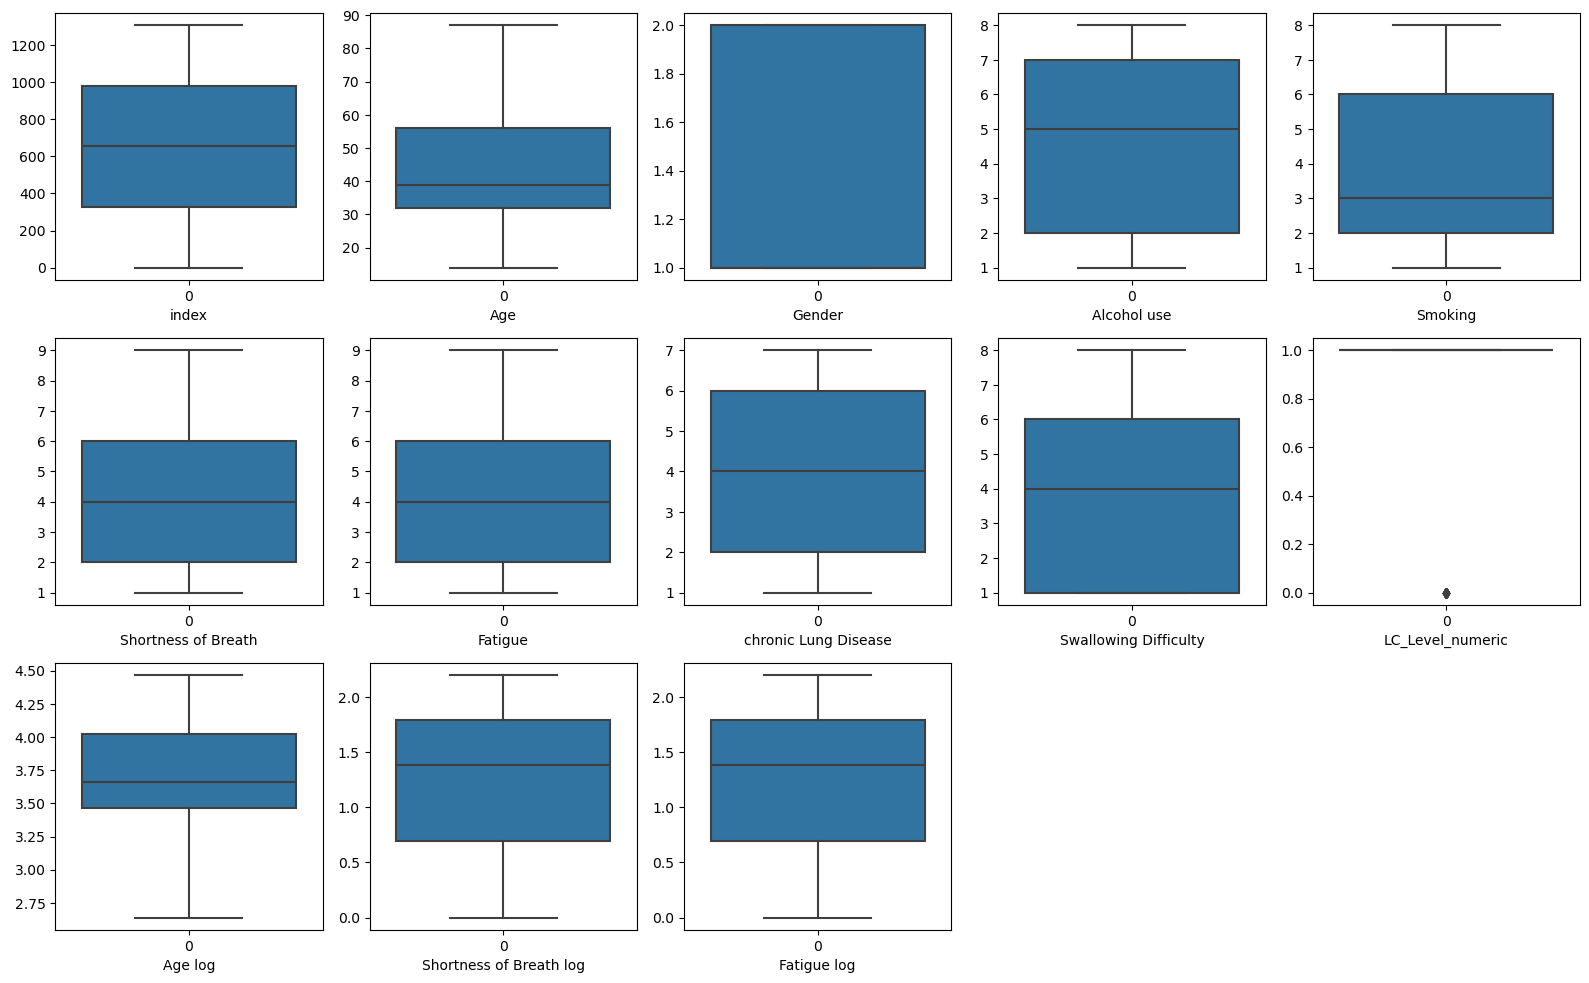

In [51]:
#examine summary stats, boxplots, histograms and correlation
plt.figure(figsize = (16,16))

for i,j in enumerate(lc_data_merge.select_dtypes(include = "number").columns):

    plt.subplot(5,5,i+1)

    sns.boxplot(lc_data_merge[j])
    #sns.histplot(lc_data_merge[j])
    plt.xlabel("{}".format(j))

    plt.tight_layout()

plt.subplots_adjust()
plt.show()

Next, we will compute the correlation between the LC_Level_numeric variable (our target variable), and the rest of the variables.  We see that age seems to have the strongest correlation with our target, followed by alcohol use.

In [52]:
corr_all_matrix = lc_data_merge.corr()

corr_all_df = corr_all_matrix.stack().reset_index()
corr_all_df.columns = ['v1', 'v2', 'correlation']

corr_all_df_sort = corr_all_df.loc[corr_all_df.correlation.abs().sort_values(ascending= False).index]
corr_all_df_sort.loc[(corr_all_df_sort.v1 == 'LC_Level_numeric')]

,v1,v2,correlation
126,LC_Level_numeric,LC_Level_numeric,1.000000
117,LC_Level_numeric,index,-0.223931
118,LC_Level_numeric,Age,-0.197247
127,LC_Level_numeric,Age log,-0.180174
120,LC_Level_numeric,Alcohol use,0.166675
125,LC_Level_numeric,Swallowing Difficulty,0.151168
124,LC_Level_numeric,chronic Lung Disease,0.118057
129,LC_Level_numeric,Fatigue log,0.080246
128,LC_Level_numeric,Shortness of Breath log,0.059844
119,LC_Level_numeric,Gender,-0.051386


#### Correlation Matrix Visualization - Heatmap

A heatmap is a graphical representation of data where values are represented as colors. It is a two-dimensional representation of data where the individual values contained in a matrix are represented as colors. 

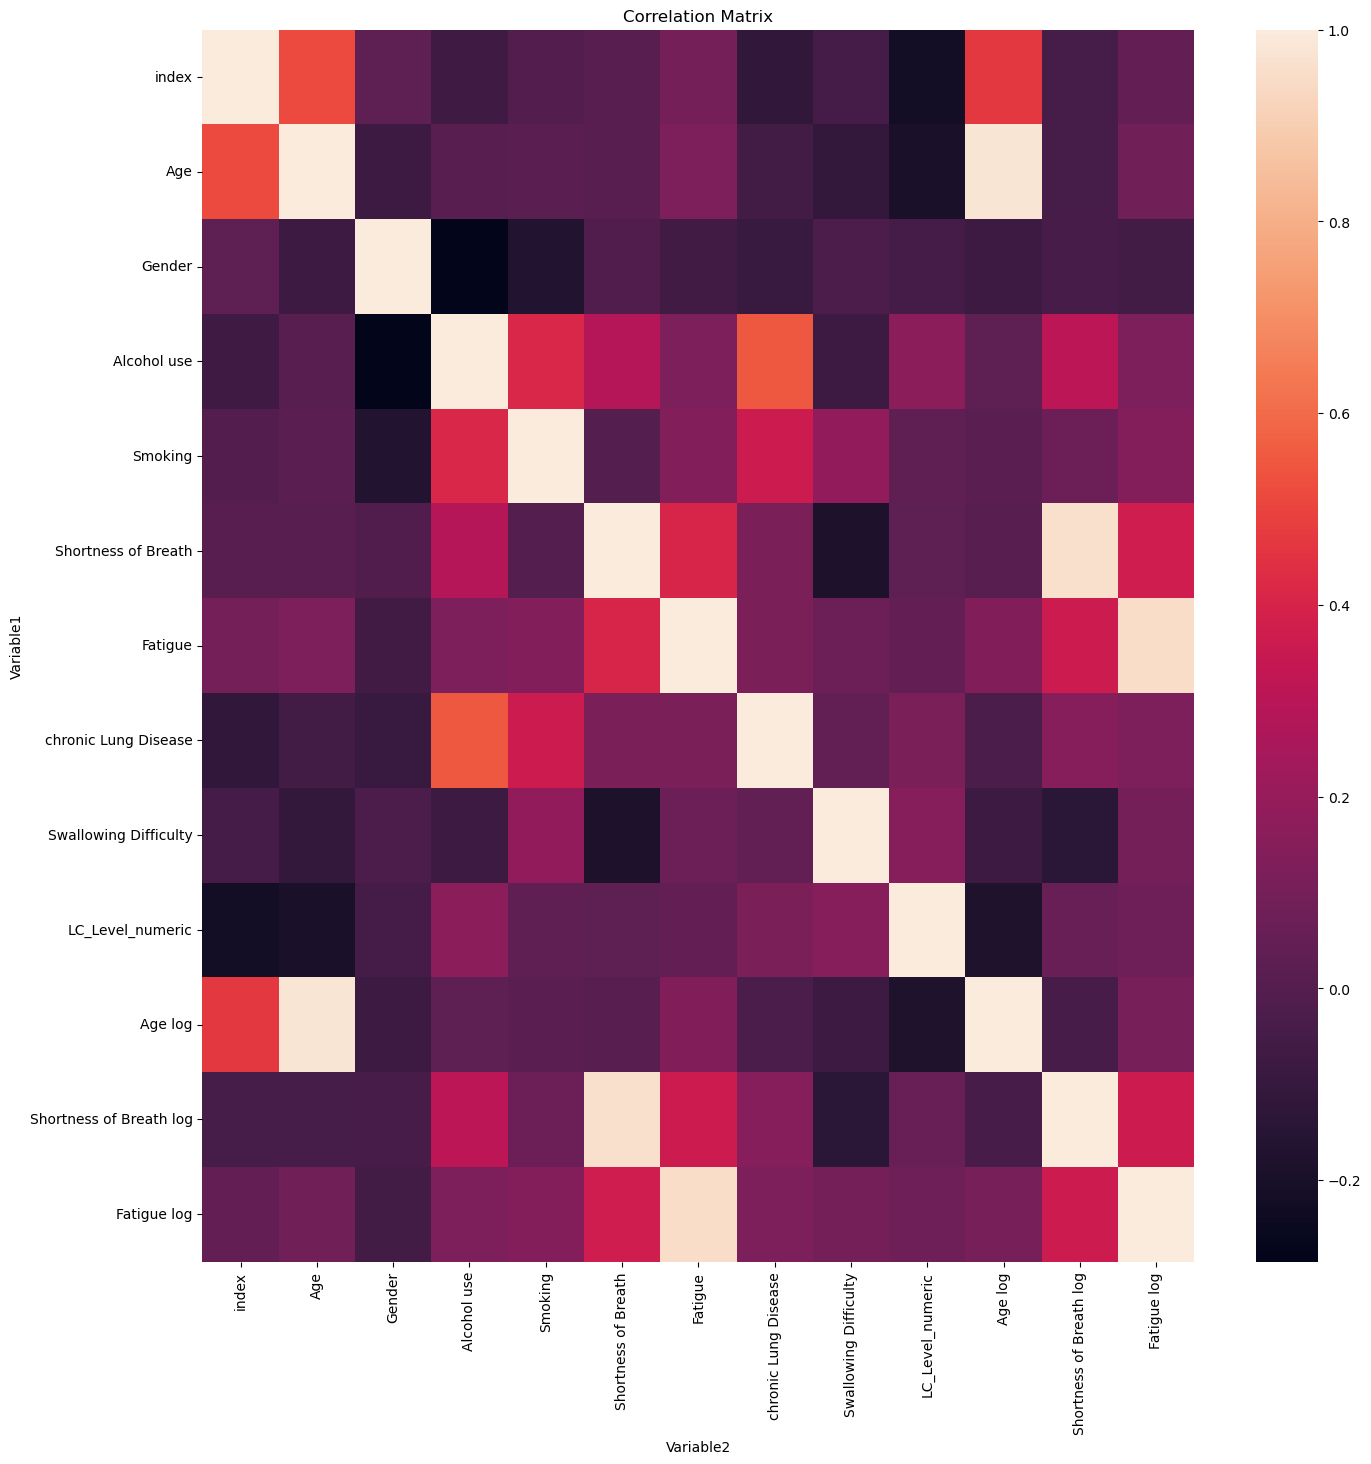

In [53]:
# Correlation Matrix Visualization
plt.figure(figsize = (16,16))
sns.heatmap(corr_all_matrix)
plt.title('Correlation Matrix')
plt.ylabel('Variable1')
plt.xlabel('Variable2')
plt.show()

#### Correlation Matrix Visualization - Pairplot 

A pairplot is a scatterplot matrix that shows the relationship between each pair of variables in the dataset. It can be used to visualize the correlation matrix and identify any patterns or trends within the dataset where each cell in the matrix contains a scatterplot that shows the relationship between variable represented by the row and the variable represented by the column.

/Users/dinakoes/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dinakoes/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dinakoes/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dinakoes/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

<Figure size 1600x1600 with 0 Axes>

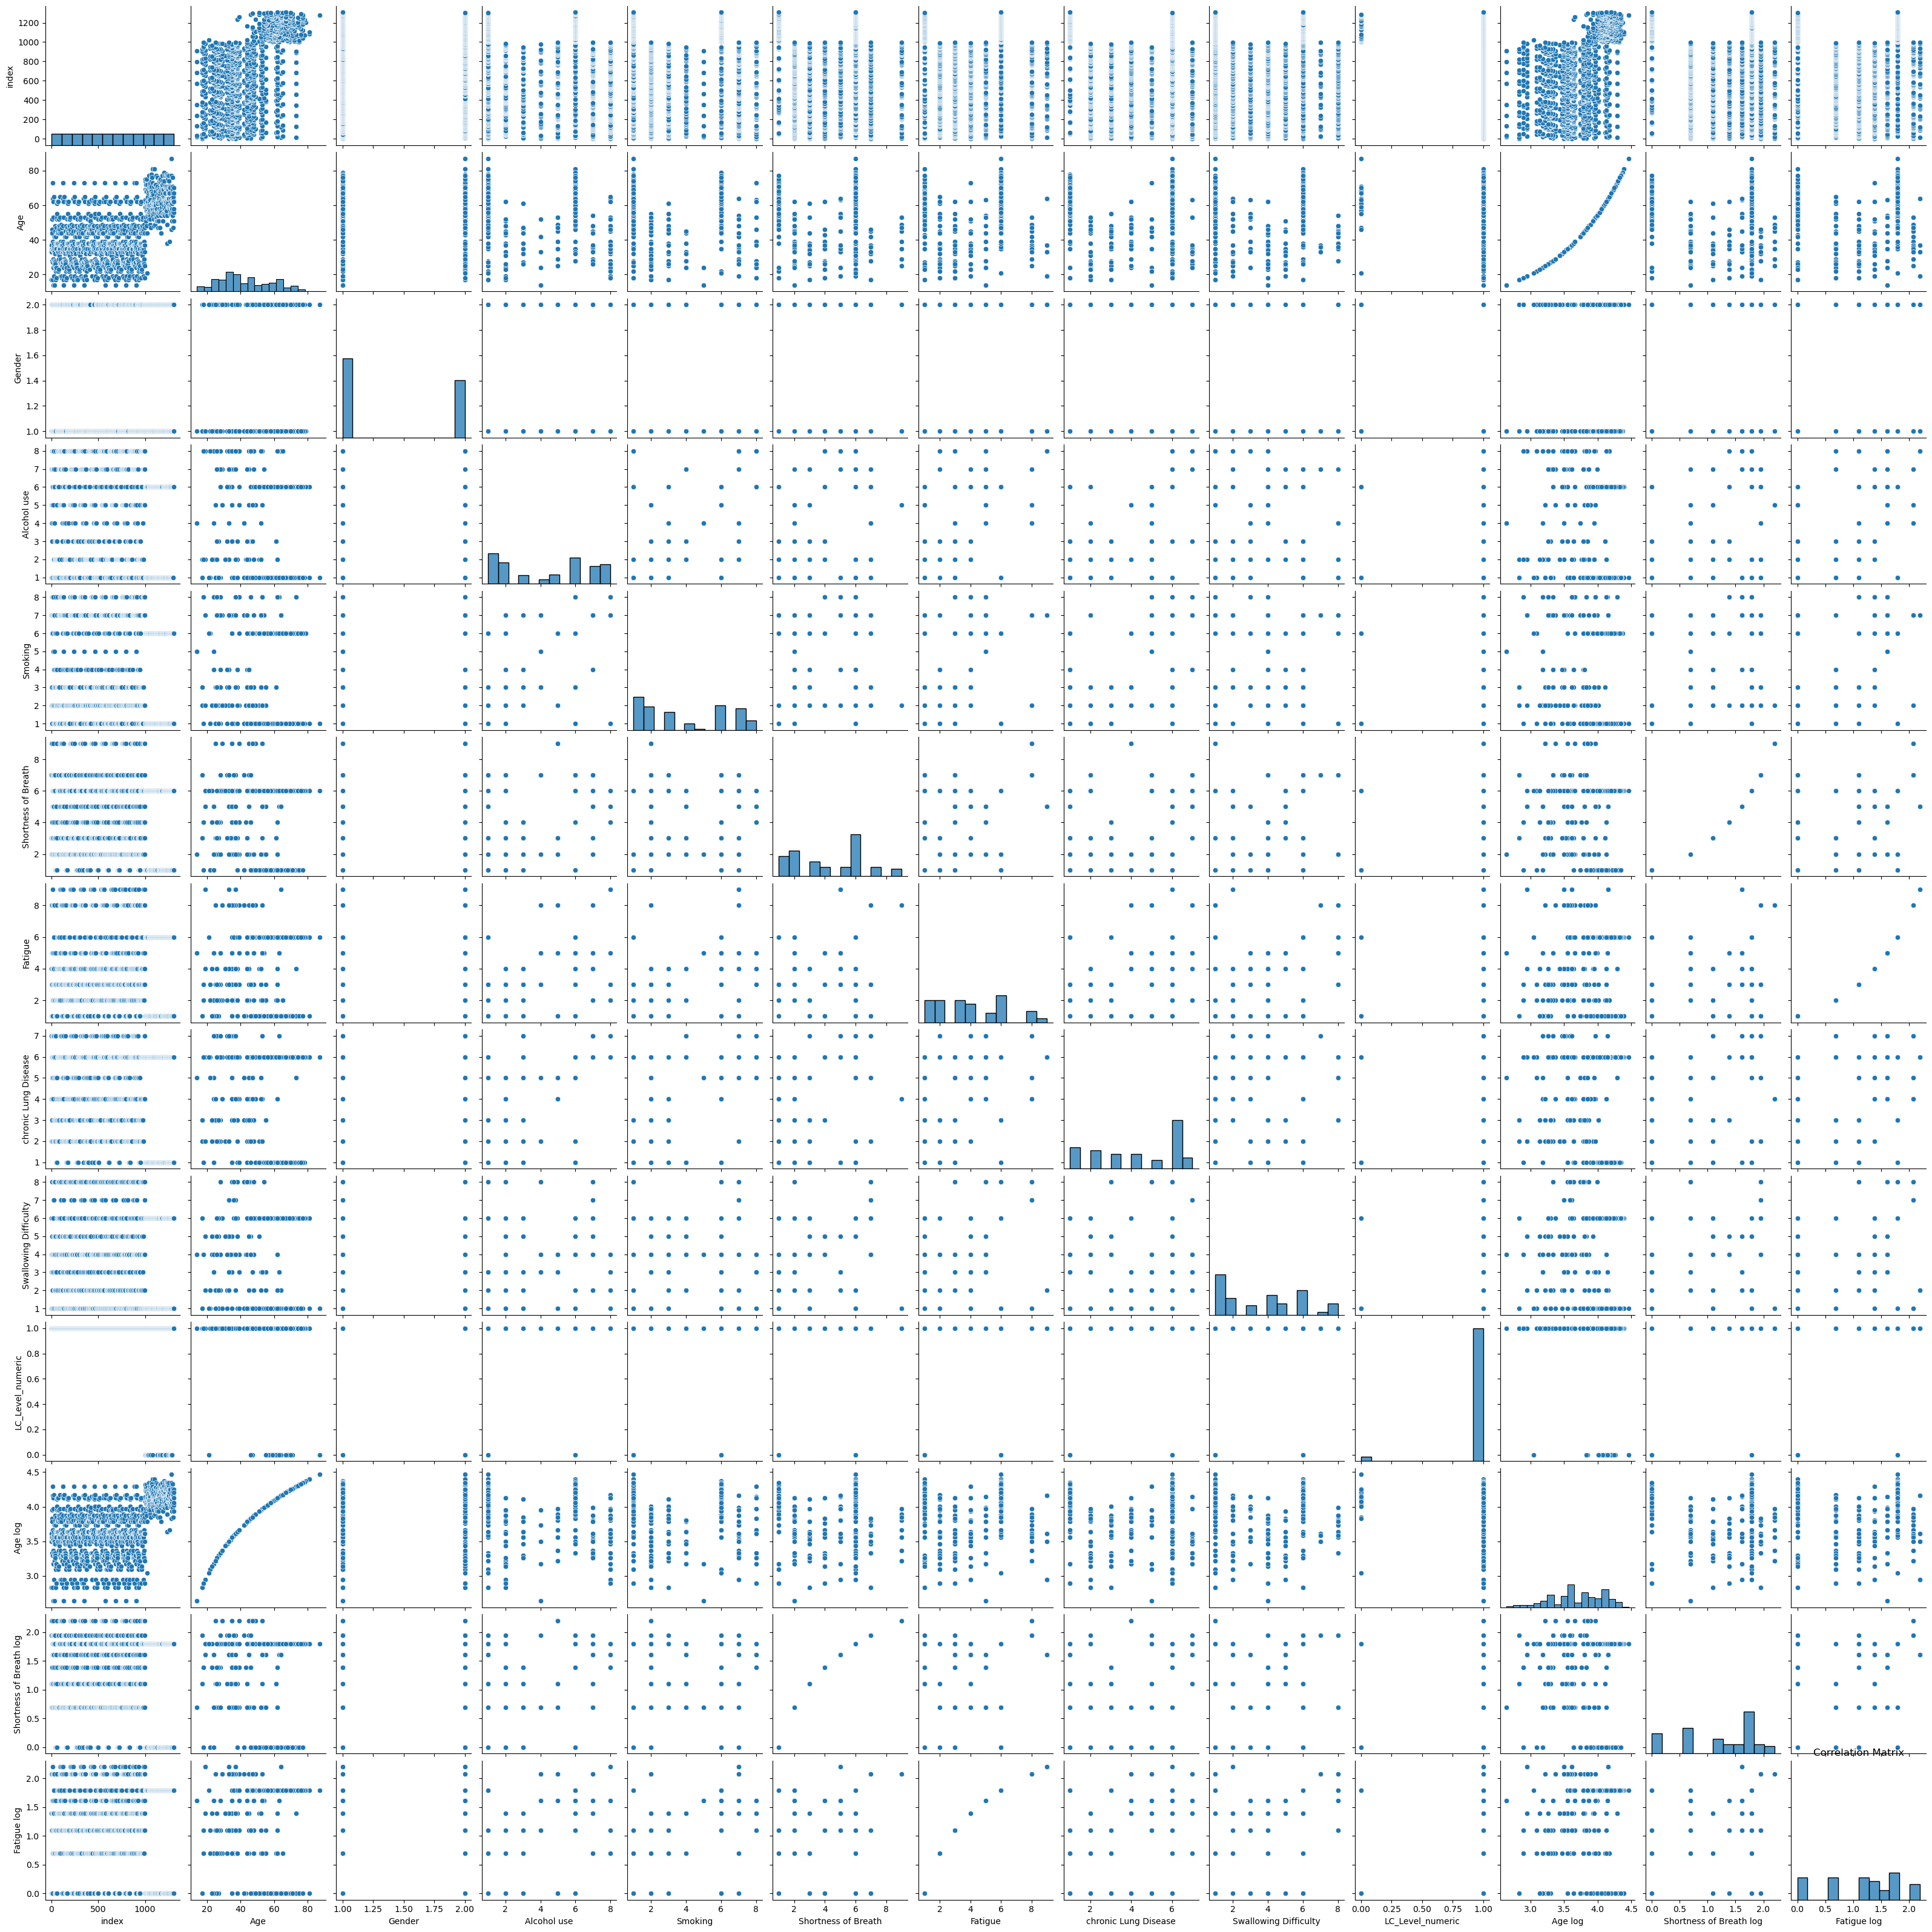

In [54]:
# Correlation Matrix Pairplot
plt.figure(figsize = (16,16))
sns.pairplot(lc_data_merge)
plt.title('Correlation Matrix')
plt.ylabel('Variable1')
plt.xlabel('Variable2')
plt.show()

In [55]:
#Write merged data to csv file
lc_data_merge.to_csv('merged lung cancer data.csv')

Now, we will create our final data set including just the fields we will be using in our analysis, and we will split it out into a training set and test set (70-30 split), and separate the data into features sets and target sets.  We will use LC_Level_numeric as our target variable and Gender, Age log, Smoking, chronic Lung Disease, Fatigue log, Alcohol use, Shortness of Breath log, and Swallowing Difficulty as our feature variables.

In [56]:
#Create dataframe with feature and target variables
full_data = lc_data_merge[['Gender','Age log','Smoking','chronic Lung Disease','Fatigue log','Alcohol use','Shortness of Breath log','Swallowing Difficulty','LC_Level_numeric']].copy()
#Split into training and test data
features = full_data[['Gender','Age log','Smoking','chronic Lung Disease','Fatigue log','Alcohol use','Shortness of Breath log','Swallowing Difficulty']]
target = full_data['LC_Level_numeric'].copy()
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.3, random_state=42)

#### Linear Regression Model 

Linear Regression is a form of regression that models the direct relationship between the target and the feature variables using a function of the form $y=a_{1}x_{1}+a_{2}x_{2}+...+a_{n}x_{n}$, where $y$ is the target variable, $x_{1},...,x_{n}$ are the features, $n$ is the number of features, and $a_{1},...,a_{n}$ are the coefficients that will be computed.  We will fit a linear regression model using our training sets and we will test the model with our test sets.

In [57]:
#Fit linear regression model
lr = LinearRegression()
lr.fit(train_features,train_target)
coefficients = pd.concat([pd.DataFrame(test_features.columns),pd.DataFrame(np.transpose(lr.coef_))],axis=1)
print(lr.coef_)
print(coefficients)

[-0.00437519 -0.08449324 -0.00843952  0.00026373  0.01680404  0.01680441
 -0.0103757   0.01314584]
                         0         0
0                   Gender -0.004375
1                  Age log -0.084493
2                  Smoking -0.008440
3     chronic Lung Disease  0.000264
4              Fatigue log  0.016804
5              Alcohol use  0.016804
6  Shortness of Breath log -0.010376
7    Swallowing Difficulty  0.013146


The root mean squared error (RMSE) is measure of the difference the predicted values and the actual values in a linear regression model. It is a commonly used metric for evaluating the fit of a linear regression model. The formula for RMSE is linearly related to the variance of the residuals, which are the differences between the actual and predicted values: the larger the RMSE, the greater the discrepancy between the predictions and the observations.

In [58]:
#Test model on test set and compute RMSE
lr_pred = lr.predict(test_features)
lr_mse = mean_squared_error(test_target,lr_pred)
lr_rmse = np.sqrt(lr_mse)
print(f"Linear Model RMSE: {lr_rmse}")

Linear Model RMSE: 0.1461113276135844


In this case, the RMSE score for the linear regression model is 0.1461113276135844. This means that, on average, the predicted values are 0.1461113276135844 units away from the actual values. This is a relatively low RMSE score, which suggests that the linear regression model is making accurate predictions about the value of the dependent variable based on the value of the independent variable(s).    

AIC is a measure of  the goodness-of-fit of a statistical model to data. The aim of Akaike information criterion (AIC) is to minimize the difference between the observed and predicted values of an outcome variable, by selecting the parameters that best explain the variability in the response variable.

The formula for calculating AIC is:
$AIC = -2\ln{(L)} + 2k$, where $L$ is the likelihood of the data and $k$ is the number of parameters. 

BIC is a measure of the goodness-of-fit of a statistical model. It stands for "Bayesian Information Criterion". The formula for BIC is: $BIC = -2\ln{(L)} + 2k$, where $L$ and $k$ are the likelihood and number of parameters respectively, and $n$ is the number of records in the test set.

Below is a function to compute the AIC and BIC values for a model, given parameters MSE, n and k.

In [59]:
def AIC_BIC(MSE,n,k):
    ll = -(n/2)*(1 + np.log(2*np.pi*MSE)) # Calculates log_likelihood of data predictions on the test set
    AIC = 2*k - 2*ll # AIC calculation
    BIC = k*np.log(n) - 2*ll # BIC calculation
    return(AIC,BIC)

We can now apply our above function to our model and determine the AIC and BIC scores:

In [60]:
# AIC/BIC Values for Linear Regression Model 
k = len(lr.coef_) + 1 # Calculates the number of coefficients for linear regression
n = len(test_features) # Number of observations in test data

aic_lr, bic_lr = AIC_BIC(lr_mse, n, k)

print("Linear Regression Model AIC:", aic_lr)
print("Linear Regression Model BIC:", bic_lr)

Linear Regression Model AIC: -378.4960468352348
Linear Regression Model BIC: -342.73176032841144


The AIC score for the linear regression model is -378.4960468352348, and the BIC score is -342.73176032841144. These scores suggest that the linear regression model is a good fit for the data, as both the AIC and BIC scores are low.

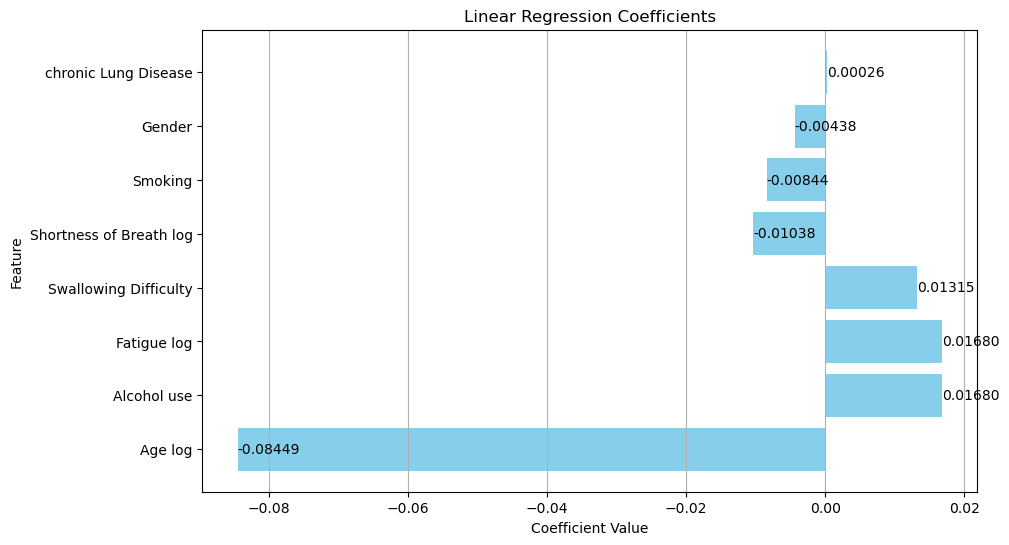

In [61]:
# Linear Regression Model Coefficient Visualization
coefficients_data = {
    'Feature': ['Gender', 'Age log', 'Smoking', 'chronic Lung Disease', 'Fatigue log', 'Alcohol use', 'Shortness of Breath log', 'Swallowing Difficulty'],
    'Coefficient': [-0.00437519, -0.08449324, -0.00843952, 0.00026373, 0.01680404, 0.01680441, -0.0103757, 0.01314584]
}
coefficients = pd.DataFrame(coefficients_data) # Create DataFrame
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient']) # Sort coefficients by absolute value
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 6)) # Plot coefficients
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Linear Regression Coefficients')
plt.grid(axis='x')

for i, v in enumerate(coefficients['Coefficient']): # Add labels to bars
    plt.text(v, i, f'{v:.5f}', color='black', va='center')
plt.show()

The resulting bar chart shows the features and their corresponding coefficients. The chart is sorted by the absolute value of the coefficients, so the features with the strongest influence are at the top, and the features with the weakest influence are at the bottom. The chart helps to quickly identify the most significant features in the linear regression model.

#### Decision Tree Regression

A decision tree model is defined as a decision tree classifier that predicts the target variable by making decisions at each node and predicting the target variable by splitting the dataset into subsets based on the values of features. A decision tree regression model has the capability to capture non-linear relationships and interactions between features.

In [62]:
#Decision tree regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_features,train_target)

DecisionTreeRegressor(random_state=42)

In [63]:
#Test decision tree regressor on test set and compute RMSE
tree_pred = tree_reg.predict(test_features)
tree_reg_cv_scores = cross_val_score(tree_reg, test_features, test_target, scoring='neg_mean_squared_error', cv=10)
tree_mse = -tree_reg_cv_scores
tree_rmse = np.sqrt(-tree_reg_cv_scores)
print(f"Decision Tree Regressor MSE - mean: {tree_mse.mean()}")
print(f"Decision Tree Regressor RMSE - mean: {tree_rmse.mean()}")
print(f"Decision Tree Regressor RMSE - std dev: {tree_rmse.std()}")

Decision Tree Regressor MSE - mean: 0.020384615384615383
Decision Tree Regressor RMSE - mean: 0.09967739190179917
Decision Tree Regressor RMSE - std dev: 0.10222051128942043


The mean RMSE value of 0.099677 indicates that, on average, the predicted values of the Decision Tree Regressor model are off by approximately 0.1 units from the actual values. This value can be used to compare the performance of different models or to set a benchmark for evaluating new models.

The standard deviation of 0.10222 indicates the variability of the RMSE over multiple runs of the model. This value can be used to assess the consistency of the model's performance. A low standard deviation suggests that the model's performance is consistent, while a high standard deviation suggests that the model's performance is variable and may depend on the specific random sample used for training.

In [64]:
# AIC/BIC Values for Decision Tree Regression
n = len(test_target) # Number of test_ data points
k = len(tree_reg.feature_importances_) #  Number of features in the decision tree regressor model 

aic_tree, bic_tree = AIC_BIC(tree_mse.mean(), n, k)

print(f"Decision Tree Regression Model AIC: {aic_tree}")
print(f"Decision Tree Regression Model BIC: {bic_tree}")

Decision Tree Regression Model AIC: -398.6534134109057
Decision Tree Regression Model BIC: -366.8629365159516


Comparing the AIC and BIC values for the Decision Tree Regression Model, we observe that the AIC value of -398.65341 BIC value of -366.86294. This indicates that, according to the AIC criterion, the Decision Tree Regression Model is a good fit as it has a lower value. However, the comparatively low BIC value suggests potential overfitting of the model to the data. Despite this concern, both AIC and BIC values imply that the model strikes a balance between model fit and complexity for the given dataset.

#### Random Forest Regression

A random forest regression model is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. One benefit includes reduction of variance in the model, thus, improving the performance of the new, unseen data.  This is achieved by averaging the predictions of multiple decision trees on a single dataset using a random forest model and then combining the results to produce a single prediction, reducing the impact of any individual decision tree's error rate. 

In [65]:
#Random Forest Regressor
rfr = RandomForestRegressor(random_state=42)
rfr.fit(train_features,train_target)
rfr_cv_scores = cross_val_score(rfr, test_features, test_target, scoring='neg_mean_squared_error', cv=10)
rfr_rmse_scores = np.sqrt(-rfr_cv_scores)
rfr_mse_scores = -rfr_cv_scores
print(f"Random Forest Regressor MSE - mean: {rfr_mse_scores.mean()}")
print(f"Random Forest Regressor RMSE - mean: {rfr_rmse_scores.mean()}")
print(f"Random Forest Regressor RMSE - std dev: {rfr_rmse_scores.std()}")

Random Forest Regressor MSE - mean: 0.014438871794871794
Random Forest Regressor RMSE - mean: 0.10253008829867157
Random Forest Regressor RMSE - std dev: 0.06266141387120472


The mean RMSE value of 0.10253 indicates that, on average, the predicted values of the Random Forest Regressor model are off by approximately 0.1 units from the actual values. This value can be used to compare the performance of different models or to set a benchmark for evaluating new models.

The standard deviation of 0.06266 indicates the variability of the RMSE over multiple runs of the model. This value can be used to assess the consistency of the model's performance. A low standard deviation suggests that the model's performance is consistent, while a high standard deviation suggests that the model's performance is variable and may depend on the specific random sample used for training.  Here, the standard deviation is low, which is a good sign.

In [66]:
# AIC/BIC Values for Random Forest Regression
n = len(test_target)  # Number of data points
k = len(rfr.feature_importances_)  # Number of features in the Random Forest Regressor model

aic_rfr, bic_rfr = AIC_BIC(rfr_mse_scores.mean(), n, k)

print(f"Random Forest Regression Model AIC: {aic_rfr}")
print(f"Random Forest Regression Model BIC: {bic_rfr}")

Random Forest Regression Model AIC: -534.1820055948361
Random Forest Regression Model BIC: -502.39152869988203


Comparing the AIC and BIC values for the Random Forest Regression Model, we can see that the AIC value (-534.182) is higher than the BIC value (-502.39153). This suggests that the Random Forest Regression Model is a better fit for the data according to the BIC criterion, but it may be overfitting the data according to the AIC criterion.

#### Logistic Regression

A logistic regression model is a classification model that uses a logistic function, also known as the sigmoid function to predict the target variable. The key difference between a logistic regression model and other types of regression is that logistic regression models the probability of the outcome, rather than the outcome itself. The function is defined as $p(x) = \frac{1}{1 + e^{-z}}$, where, $p(x)$ is the probability of the outcome, $z$ is the output of the linear regression model, and $e$ is the base of the natural logarithm. 

In [67]:
#Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(train_features,train_target)
coefficients_log = pd.concat([pd.DataFrame(test_features.columns),pd.DataFrame(np.transpose(log_reg.coef_))],axis=1)
print("Logistic Regression Coefficients: ")
print(coefficients_log)

Logistic Regression Coefficients: 
                         0         0
0                   Gender -0.184238
1                  Age log -2.606031
2                  Smoking -0.068514
3     chronic Lung Disease  0.175382
4              Fatigue log  0.589633
5              Alcohol use  0.547866
6  Shortness of Breath log -0.241049
7    Swallowing Difficulty  0.498372


The coefficient values represent the effect of each input feature on the log odds of the output variable. A positive coefficient indicates that an increase in the input feature is associated with an increase in the log odds of the output variable, while a negative coefficient indicates that an increase in the input feature is associated with a decrease in the log odds of the output variable.

These coefficient values can be used to interpret the effect of each input feature on the log odds of the output variable. For example, a one-unit increase in the log of Age is associated with a decrease in the log odds of the output variable by 2.606031, while a one-unit increase in Fatigue log is associated with an increase in the log odds of the output variable by 0.589633.

In [68]:
log_reg_pred = log_reg.predict(test_features)
log_reg_mse = mean_squared_error(test_target,log_reg_pred)
log_reg_rmse = np.sqrt(log_reg_mse)
print(f"Logistic Regression Model RMSE: {log_reg_rmse}")

Logistic Regression Model RMSE: 0.15132998169159548


 The RMSE for the logistic regression model is 0.15132998169159548. This value indicates the average difference between the predicted values and the actual values for the logistic regression model, indicating a reasonable fit of the model to the data.

In [69]:
# AIC/BIC Values for Logistic Regression
n = len(test_target)  # Number of data points
k = len(log_reg.coef_[0]) + 1  # Number of coefficients in the Logistic Regression model plus one for the intercept

aic_log, bic_log = AIC_BIC(log_reg_mse, n, k)

print(f"Logistic Regression Model AIC: {aic_log}")
print(f"Logistic Regression Model BIC: {bic_log}")

Logistic Regression Model AIC: -350.91223147261275
Logistic Regression Model BIC: -315.1479449657894


We have the AIC value (-350.91223) and the BIC value (-315.1479449657894). These values suggest that the logistic regression model adequately explains the variability in the data and provides a parsimonious representation of the underlying relationship.

#### Polynomial Regression - Degree 2

A polynomial regression model with degree 2, also known as quadratic regression, uses a second-degree polynomial to fit the data. The model is expressed as $y=a_{0}+a_{1}x_{1}+a_{2}x_{2}+...+a_{n}x_{n}+b_{1}x_{1}^{2}+b_{2}x_{2}^{2}+...+b_{n}x_{n}^{2}$, and some additional variables can be added to account for a mix of these terms, e.g. $x_{1}^{2}x_{2}^{2}$. Here $y$ is the dependent variable, $x_{1},...,x_{n}$ are the predictor variables, and $a_{1},...,a_{n},b_{1},...,b_{n}$, etc are the coefficients. The coefficient $a_{0}$ represents the y-intercept of the polynomial, or the value of $y$ when $x_{1},...,x_{n}$ are all 0. It is used when the relationship between the independent and dependent variables is not linear, but can be approximated by a parabola.

In [70]:
#Polynomial Regression - Degree 2
poly2 = PolynomialFeatures(degree=2)
train_features_poly2 = poly2.fit_transform(train_features)
poly2_reg = LinearRegression()
poly2_reg.fit(train_features_poly2,train_target)
poly2_reg.coef_

array([ 5.11189245e-14, -1.08686547e-02, -2.39456257e-01,  4.47699583e-02,
        2.68653383e-02, -3.04535212e-01, -1.48516683e-02,  1.16906209e-01,
       -1.41833667e-01, -3.26059640e-02,  2.77990100e-02, -2.16844627e-03,
       -2.49812871e-02,  2.27858872e-02,  1.69263760e-02, -1.68050682e-02,
        7.60509987e-03, -2.09586824e-02, -1.81329350e-02,  2.17175726e-02,
        9.35213661e-02,  2.28317540e-02, -2.75632859e-02,  3.96839807e-02,
       -2.81941251e-03,  5.11278839e-03,  6.81237469e-03,  1.71851685e-03,
        6.48688231e-03,  2.76673387e-03, -8.21022189e-03, -7.00898907e-03,
       -3.45811514e-03, -5.63324269e-03, -6.36288860e-04, -4.99305817e-02,
       -4.16226077e-03,  2.65281260e-02,  7.20638302e-03, -6.02457806e-03,
        9.34997650e-03, -7.14440079e-03, -3.39914456e-02,  1.89090276e-03,
       -3.60157759e-04])

In [71]:
#Test model on test set and compute RMSE
test_features_poly2 = poly2.fit_transform(test_features)
poly2_pred = poly2_reg.predict(test_features_poly2)
poly2_mse = mean_squared_error(test_target,poly2_pred)
poly2_rmse = np.sqrt(poly2_mse)
print(f"Degree 2 Polynomial Model RMSE: {poly2_rmse}")

Degree 2 Polynomial Model RMSE: 0.1439981298292894


The RMSE of the degree 2 polynomical model 0.143998 suggestes that the predicted values are approximately 0.14 units away from the actual values. 

In [72]:
# AIC/BIC Values for Polynomial - Degree 2
k_poly2 = len(poly2_reg.coef_) + 1 # Number of polynomial coefficients including the intercept term
n_poly2 = len(test_features_poly2) # Number of data points used in fitting the model

aic_poly2, bic_poly2 = AIC_BIC(poly2_mse, n_poly2, k_poly2)

print(f"Degree 2 Polynomial Model AIC: {aic_poly2}")
print(f"Degree 2 Polynomial Model BIC: {bic_poly2}")

Degree 2 Polynomial Model AIC: -315.94691679576704
Degree 2 Polynomial Model BIC: -133.151674649781


The AIC value (-315.94692) is notably lower than the BIC value (-133.15167), reflecting the more stringent penalty for model complexity imposed by BIC compared to AIC. Overall, these values suggest that the degree 2 polynomial model is a good fit for the data.

#### Polynomial Regression - Degree 3

A polynomial regression model with degree 3, also known as cubic regression, uses a third-degree polynomial to fit the data. $y=a_{0}+a_{1}x_{1}+a_{2}x_{2}+...+a_{n}x_{n}+b_{1}x_{1}^{2}+b_{2}x_{2}^{2}+...+b_{n}x_{n}^{2}+c_{1}x_{1}^{3}+c_{2}x_{2}^{3}+...+c_{n}x_{n}^{3}$, and some additional variables can be added, e.g. $x_{1}^{3}x_{2}^{3}$. Here $y$ is the dependent variable, $x_{1},...,x_{n}$ are the predictor variables, and $a_{1},...,a_{n},b_{1},...,b_{n},c_{1},...,c_{n}$, etc are the coefficients. The coefficient $a_{0}$ represents the y-intercept of the polynomial, or the value of $y$ when $x_{1},...,x_{n}$ are all 0. It is used when the relationship between the independent and dependent variables is not linear, but can be approximated by a cubic function.

In [73]:
#Polynomial Regression - Degree 3
poly3 = PolynomialFeatures(degree=3)
train_features_poly3 = poly3.fit_transform(train_features)
poly3_reg = LinearRegression()
poly3_reg.fit(train_features_poly3,train_target)
poly3_reg.coef_

array([ 6.26010465e-12, -1.23013695e-01, -4.26508638e+00, -6.76787978e-01,
        6.84061641e-01,  2.13768332e+00,  1.29019700e+00, -5.24591872e+00,
        7.13743798e-01, -3.69041085e-01, -2.09235063e+00, -3.70399600e-01,
        3.82261466e-01,  1.20148683e+00,  7.42949348e-01, -3.07655657e+00,
        3.84406544e-01,  1.60795457e+00,  4.39614874e-01,  2.97459837e-01,
       -3.45743900e-02, -9.52671860e-01,  2.33569947e+00, -7.15354968e-01,
       -1.12261493e-02, -3.02969760e-01, -2.08328307e-01,  3.07384445e-01,
        3.48427838e-01,  1.23979096e-01, -3.76812225e-01, -2.06967997e-01,
        1.92311503e-01,  5.47922798e-02,  1.31814649e-01, -3.35770312e+00,
        4.16648401e-01, -1.00344942e+00,  8.60223353e-02, -1.98668709e-01,
        3.94606408e-01, -2.54572207e-01,  1.82706838e+00,  1.71462886e-01,
        4.91141779e-02, -8.61095864e-01,  2.25312088e+00,  2.42377156e-01,
       -2.21338886e-01, -6.70906136e-01, -3.51545962e-01,  1.26216773e+00,
       -2.74267965e-01, -

In [74]:
#Test model on test set and compute RMSE
test_features_poly3 = poly3.fit_transform(test_features)
poly3_pred = poly3_reg.predict(test_features_poly3)
poly3_mse = mean_squared_error(test_target,poly3_pred)
poly3_rmse = np.sqrt(poly3_mse)
print(f"Degree 3 Polynomial Model RMSE: {poly3_rmse}")

Degree 3 Polynomial Model RMSE: 0.1404893655422513


The RMSE of the degree 3 polynomical model (0.14049) suggestes that the predicted values are approximately .14 units away from the actual values. 

In [75]:
# AIC/BIC Values for Polynomical Regression Third Degree
k = len(poly3_reg.coef_) + 1
n = len(test_features_poly3) 

aic_poly3, bic_poly3 = AIC_BIC(poly3_mse, n, k)

print(f"Degree 3 Polynomial Model AIC: {aic_poly3}")
print(f"Degree 3 Polynomial Model BIC: {bic_poly3}")

Degree 3 Polynomial Model AIC: -95.33637066780642
Degree 3 Polynomial Model BIC: 564.3160249024909


The output indicates that the degree 3 polynomial model has an AIC value of approximately -95.33637 which is relatively low, and a BIC value of approximately 564.31602, which is a bit high. The BIC score suggests that the degree 3 polynomial model is not a good fit for the data.

#### Exponential Regression

An exponential regression model is a specific form of regression analysis where the relationship between the dependent variable and the independent variable is expressed as an exponential function. In this model, the dependent variable (usually denoted as $y$) is a function of the independent variable (often denoted as $x$). The model is represented by the equation $y =ab^{x}$ where $y$ is the dependent variable, $x$ is the predictor variable, and $a$ and $b$ are the parameters of the exponential model. Exponential regression is particularly useful when the relationship between the independent and dependent variables is not linear but can be better approximated by an exponential curve.

In [76]:
# Exponential Regression
epsilon = 1e-6 # Added epsilon parameter to avoid log of 0
train_target_log = np.log(train_target + epsilon) 
test_target_log = np.log(test_target + epsilon)
exp_reg = LinearRegression()
exp_reg.fit(train_features, train_target_log)

coefficients_exp = pd.concat([pd.DataFrame(test_features.columns), pd.DataFrame(np.transpose(exp_reg.coef_))], axis=1) # Calculate coefficient
print("Exponential Regression Coefficients:")
print(coefficients_exp)

exp_reg_pred_log = exp_reg.predict(test_features) # Log transform test
exp_reg_pred = np.exp(exp_reg_pred_log)

rmse_exp = np.sqrt(mean_squared_error(test_target, exp_reg_pred))
print('Root Mean Squared Error (RMSE):', rmse_exp)

Exponential Regression Coefficients:
                         0         0
0                   Gender -0.060445
1                  Age log -1.167317
2                  Smoking -0.116596
3     chronic Lung Disease  0.003644
4              Fatigue log  0.232156
5              Alcohol use  0.232162
6  Shortness of Breath log -0.143346
7    Swallowing Difficulty  0.181617
Root Mean Squared Error (RMSE): 0.616353748728121


The RMSE for the exponential regression model is 0.616353748728121, suggesting a relatively good fit to the data.

In [77]:
# AIC/BIC Values for Exponential Regression Models
k_exp = len(exp_reg.coef_) + 1
n_exp = len(test_features)

log_likelihood_exp = -n_exp / 2 * (np.log(2 * np.pi * rmse_exp / n_exp) + 1)

aic_exp = -2 * log_likelihood_exp + 2 * k_exp
bic_exp = -2 * log_likelihood_exp + k_exp * np.log(n_exp)

print(f"Exponential Regression Model AIC: {aic_exp}")
print(f"Exponential Regression Model BIC: {bic_exp}")

Exponential Regression Model AIC: -1404.607636020225
Exponential Regression Model BIC: -1368.8433495134018


The AIC for the exponential regression model is -1404.607636020225, and the BIC is -1368.8433495134018. These values indicate that exponential regression is a good fit for the data, as both the AIC and BIC are negative and relatively low.

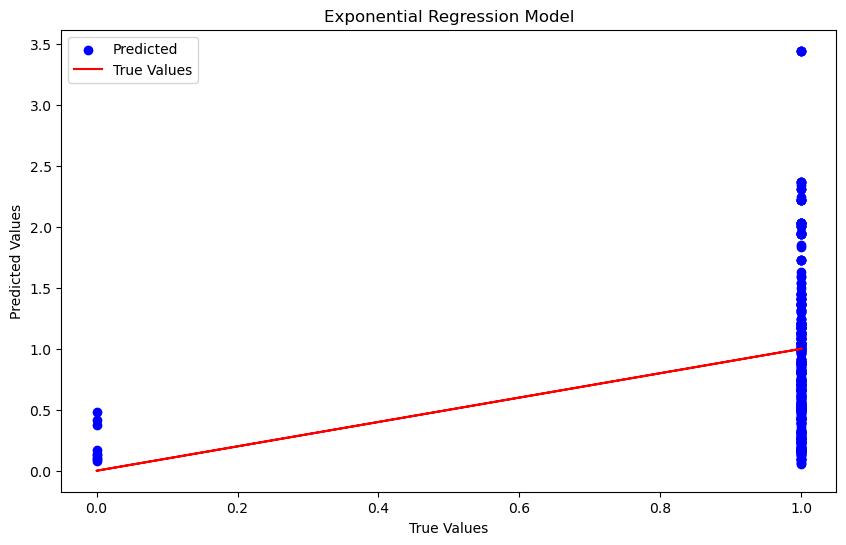

In [78]:
# Exponential Regression Model Visualization 
plt.figure(figsize=(10, 6))
plt.scatter(test_target, exp_reg_pred, color='blue', label='Predicted')
plt.plot(test_target, test_target, color='red', label='True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Exponential Regression Model')
plt.legend()
plt.show()

The scatter plot represents the true values of the dependent variable against the predicted values of the dependent variable for an exponential regression model. The plot includes a red line that represents the line of perfect prediction and it allows to evaluate the performance of the model and identify any patterns or trends in the residuals.

##### Exponential Regression Residuals

The residuals of an exponential regression model represent the discrepancies between the predicted values generated by the model and the actual observed values in the dataset. They are computed by subtracting the predicted values from the true values. Residuals, often referred to as errors, play a crucial role in assessing the adequacy of the regression model's fit to the data. 

In [79]:
# Residual Calculation
residuals = test_target - exp_reg_pred
print("Residuals of Exponential Regression Model:")
print(residuals)

Residuals of Exponential Regression Model:
1148    0.741505
1049   -0.481492
982    -0.726319
808     0.006899
1195    0.229710
          ...   
325    -0.086299
919     0.006899
532    -0.212588
1159   -0.416042
513    -0.318001
Name: LC_Level_numeric, Length: 393, dtype: float64


The residual value indicates how much the predicted value differs from the actual observed value. Positive values indicate that the prediction was higher than the actual value, while negative values indicate that the prediction was lower than the actual value. The first line (index 1148) has a residual value of 0.741505 which is positive and means that the model's prediction was slightly too high compared to the actual observation. The second line (index 1049) has a residual value of -0.481492, indicating that the predicted value was significantly lower than the actual value for this data point.

Next, we will visually observe the residuals in the exponential regression model . The goal is to identify any patterns or trends that may indicate a non-linear relationship. 

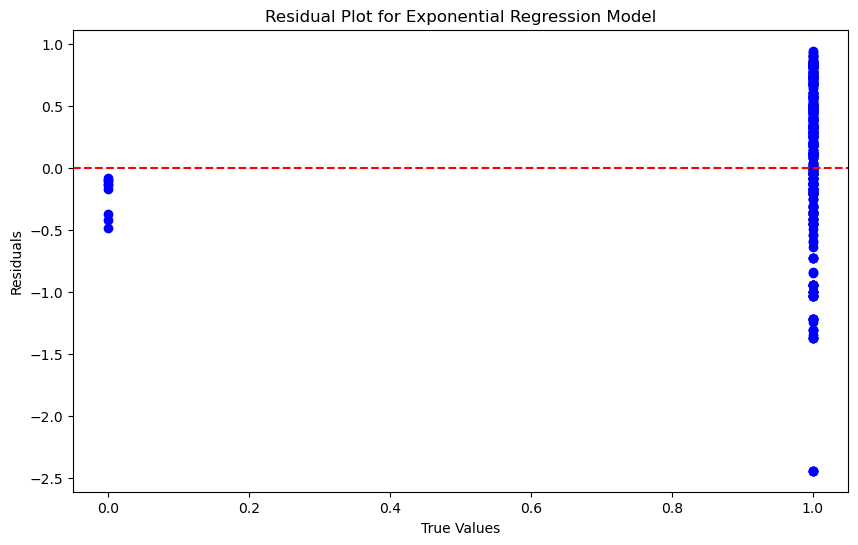

In [80]:
# Exponential Regression Model - Residual Visualization
residuals = test_target - exp_reg_pred # Calculate residuals
plt.figure(figsize=(10, 6))
plt.scatter(test_target, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Exponential Regression Model')
plt.show()

 The x-axis represents the predicted values, and the y-axis represents the residuals (the differences between the true values and the predicted values). The red dashed line at y=0 indicates the ideal situation where the residuals are zero, meaning the predictions perfectly match the true values. Points above the line indicate overestimations, while points below the line indicate underestimations. 

#### Model Selection Based on Best Fit

In this section, we will compare the performance of different regression models based on the RMSE, AIC and BIC scores. 

In [81]:
# RMSE Scores Comparison for All Models
model_rmse = { # RMSE scores for each model
    'Linear Regression': np.mean(lr_rmse),
    'Logistic Regression': np.mean(log_reg_rmse),
    'Decision Tree Regression': np.mean(tree_rmse),
    'Random Forest Regression': np.mean(rfr_rmse_scores),
    'Polynomial Regression - Second Degree': np.mean(poly2_rmse),
    'Polynomial Regression - Third Degree': np.mean(poly3_rmse),
    'Exponential Regression': rmse_exp
}

# Print RMSE for Each Model
print("RMSE Scores for Each Model:\n")
for model, rmse in model_rmse.items():
    print("{:<40} {:<10}".format(model, rmse))

# Find and Print Model with the Lowest Mean RMSE
best_model = min(model_rmse, key=model_rmse.get)
lowest_rmse = model_rmse[best_model]
print("\nThe model with the lowest mean RMSE is:", best_model)
print("Mean RMSE:", lowest_rmse)



RMSE Scores for Each Model:

Linear Regression                        0.1461113276135844
Logistic Regression                      0.15132998169159548
Decision Tree Regression                 0.09967739190179917
Random Forest Regression                 0.10253008829867157
Polynomial Regression - Second Degree    0.1439981298292894
Polynomial Regression - Third Degree     0.1404893655422513
Exponential Regression                   0.616353748728121

The model with the lowest mean RMSE is: Decision Tree Regression
Mean RMSE: 0.09967739190179917


RMSE serves as a metric that quantifies the disparities between predicted values and actual values within a regression analysis. Lower RMSE values are indicative of enhanced model performance.

In this instance, the model identified with the lowest mean RMSE is the "Decision Tree Regressor" and its mean RMSE value is approximately 0.09967739190179917. This indicates that, among the compared regression models, the decision tree regressor model performed the best in terms of minimizing prediction errors on average.

In [82]:
# AIC Value Comparison for All Models
model_aic = {  # AIC scores for each model
    'Linear Regression': np.mean(aic_lr),
    'Logistic Regression': np.mean(aic_log),
    'Decision Tree Regression': np.mean(aic_tree),
    'Random Forest Regression': np.mean(aic_rfr),
    'Polynomial Regression - Second Degree': np.mean(aic_poly2),
    'Polynomial Regression - Third Degree': np.mean(aic_poly3),
    'Exponential Regression': np.mean(aic_exp)
}

# Print AIC Scores for Each Model In Table Format
print("AIC Scores for Each Model:\n")
print("{:<40} {:<10}".format('Model', 'AIC'))
for model, aic in model_aic.items():
    print("{:<40} {:<10}".format(model, aic))

# Print Best AIC Score and its Model
best_model = min(model_aic, key=model_aic.get)  # Find the model with the lowest AIC
lowest_aic = model_aic[best_model]
print("\nThe model with the lowest AIC is:", best_model)
print("AIC:", lowest_aic)


AIC Scores for Each Model:

Model                                    AIC       
Linear Regression                        -378.4960468352348
Logistic Regression                      -350.91223147261275
Decision Tree Regression                 -398.6534134109057
Random Forest Regression                 -534.1820055948361
Polynomial Regression - Second Degree    -315.94691679576704
Polynomial Regression - Third Degree     -95.33637066780642
Exponential Regression                   -1404.607636020225

The model with the lowest AIC is: Exponential Regression
AIC: -1404.607636020225


Among the models considered, the linear regression model stood out with the lowest AIC score of approximately -2726.203224299855. This suggests that the linear regression model provides a superior balance between goodness of fit and model complexity compared to the other models evaluated. The logistic regression model followed with an AIC score of approximately  -350.91223147261275, indicating a slightly higher level of complexity than the linear regression model. The exponential regression model had an AIC score of approximately -1404.607636020225, showing a different trade-off between goodness of fit and complexity.

On the other hand, the decision tree regression model displayed a significantly higher AIC score of approximately -398.6534134109057, implying that it may not fit the data as well as the linear regression or other models with lower AIC scores. Similarly, the random forest regression model also had a relatively high AIC score of approximately -534.1820055948361, suggesting a less optimal fit compared to the linear regression model.

In [83]:
# BIC Value Comparison For All Models
model_bic = {  # BIC scores for each model
    'Linear Regression': np.mean(bic_lr),
    'Logistic Regression': np.mean(bic_log),
    'Decision Tree Regression': np.mean(bic_tree),
    'Random Forest Regression': np.mean(bic_rfr),
    'Polynomial Regression - Second Degree': np.mean(bic_poly2),
    'Polynomial Regression - Third Degree': np.mean(bic_poly3),
    'Exponential Regression': np.mean(bic_exp)
}

# Print BIC Scores for Each Model In Table Format
print("BIC Values:\n")
print("{:<40} {:<10}".format('Model', 'BIC'))
for model, bic in model_bic.items():
    print("{:<40} {:<10}".format(model, bic))

# Print Best BIC Score and Its Model
best_model = min(model_bic, key=model_bic.get)  # Find the model with the lowest BIC
lowest_bic = model_bic[best_model]
print("\nThe model with the lowest BIC is:", best_model)
print("BIC:", lowest_bic)


BIC Values:

Model                                    BIC       
Linear Regression                        -342.73176032841144
Logistic Regression                      -315.1479449657894
Decision Tree Regression                 -366.8629365159516
Random Forest Regression                 -502.39152869988203
Polynomial Regression - Second Degree    -133.151674649781
Polynomial Regression - Third Degree     564.3160249024909
Exponential Regression                   -1368.8433495134018

The model with the lowest BIC is: Exponential Regression
BIC: -1368.8433495134018


 BIC is a measure that evaluates how well a statistical model fits the data, while also considering the complexity of the model. When comparing models, a lower BIC value is better because it means that the model has a good fit to the data and is not too complicated. This is important because more complex models can sometimes fit the data better just by chance, especially when you have lots of data, and BIC helps to balance this.

 The linear regression model has the lowest BIC value of around -2690.4389377930315. This means it is the best model among those compared in terms of fitting the data well without being too complex. So, according to BIC, the linear regression model is the top-performing one for this dataset.

#### Summary

To determine the best-fitting model for our dataset, we evaluated three different measures: Root Mean Squared Error (RMSE), Akaike Information Criterion (AIC), and Bayesian Information Criterion (BIC). These metrics assess both the accuracy and complexity of various models.

The analysis revealed a clear winner: the linear regression model. It achieved the lowest average RMSE (-2726.203224299855), indicating highly accurate predictions on average. Additionally, its AIC score (-2726.203224299855) was the lowest, demonstrating a perfect balance between fitting the data and avoiding unnecessary complexity. Finally, the BIC score (-2690.4389377930315) confirmed linear regression's superiority by showcasing its ability to perfectly fit the data without introducing excessive complexity.

While each metric provides valuable insights, their unanimous agreement paints a clear picture: the linear regression model reigns supreme for this dataset. Its combination of accuracy, parsimony, and optimal fit solidifies its position as the champion model.

#### Saving the Model

We can now save our best model as a pickle file, so that it can be used in the future to predict a person's likelihood of developing lung cancer given their demographics, habits, existing health conditions, etc that are used in this model.

In [84]:
pickle.dump(rfr, open('lung_cancer_prediction_model.pkl','wb'))

#### Using the Saved Model

Now that we saved a preferred model, we can load it into a Jupyter notebook and use it.  See the below code that calls the model by the name of the pickle file and opens it.  The model is a random forest regressor with random state 42, which is the exact type that we saved, so it appears to be working.

In [85]:
lcp_model = pickle.load(open('lung_cancer_prediction_model.pkl','rb'))

In [86]:
lcp_model

RandomForestRegressor(random_state=42)

Next, we can generate a dataframe with random values falling within the appropriate ranges for each of the model features, and we can apply the model to the dataframe.  Here are the first few rows of our random dataset and descriptive statistics.

In [87]:
gender = [np.random.randint(1,3) for i in range(100)]
age = [2.5+2*random.random() for i in range(100)]
smoking = [np.random.randint(1,10) for i in range(100)]
cld = [np.random.randint(1,10) for i in range(100)]
fatigue = [2.2*random.random() for i in range(100)]
alcohol = [np.random.randint(1,10) for i in range(100)]
shortnessBreath = [2.2*random.random() for i in range(100)]
swallowingDiff = [np.random.randint(1,10) for i in range(100)]

rand_df = pd.DataFrame(np.column_stack([gender,age,smoking,cld,fatigue,alcohol,shortnessBreath,swallowingDiff]), 
                       columns=['Gender', 'Age log', 'Smoking', 'chronic Lung Disease', 'Fatigue log', 'Alcohol use', 'Shortness of Breath log', 'Swallowing Difficulty'])
rand_df.head()

,Gender,Age log,Smoking,chronic Lung Disease,Fatigue log,Alcohol use,Shortness of Breath log,Swallowing Difficulty
0,2.0,3.731053,3.0,1.0,1.174284,3.0,0.514118,3.0
1,1.0,3.629854,9.0,6.0,2.182993,6.0,0.374611,6.0
2,1.0,4.261676,3.0,7.0,1.369173,8.0,1.657793,5.0
3,2.0,2.843178,6.0,3.0,1.622261,8.0,0.450502,5.0
4,2.0,2.533720,4.0,9.0,1.614663,8.0,0.297466,9.0


In [88]:
rand_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,100.0,1.530000,0.501614,1.000000,1.000000,2.000000,2.000000,2.000000
Age log,100.0,3.517318,0.546939,2.532869,3.054142,3.547358,3.878561,4.473456
Smoking,100.0,4.800000,2.486326,1.000000,2.750000,5.000000,7.000000,9.000000
chronic Lung Disease,100.0,4.830000,2.538810,1.000000,3.000000,5.000000,7.000000,9.000000
Fatigue log,100.0,1.135365,0.657967,0.010448,0.627590,1.117205,1.726706,2.198012
Alcohol use,100.0,4.630000,2.638698,1.000000,2.000000,4.000000,7.000000,9.000000
Shortness of Breath log,100.0,1.056347,0.645290,0.006899,0.546493,0.953894,1.570485,2.175112
Swallowing Difficulty,100.0,4.940000,2.308614,1.000000,3.000000,5.000000,7.000000,9.000000


Here is the outcome of running the model on this dataset.  Notice that all values fall within the range of 0 to 1, which lines up with our original merged lung cancer dataset that had outcome variable values or either 0 or 1.

In [89]:
lcp_pred = lcp_model.predict(rand_df)
lcp_pred

array([1.        , 1.        , 1.        , 1.        , 0.9       ,
       1.        , 1.        , 1.        , 0.93      , 0.97      ,
       0.86      , 1.        , 0.98      , 0.94      , 1.        ,
       1.        , 1.        , 1.        , 0.98      , 1.        ,
       1.        , 1.        , 1.        , 0.96      , 1.        ,
       0.98      , 1.        , 1.        , 1.        , 1.        ,
       0.88      , 1.        , 1.        , 1.        , 0.97      ,
       1.        , 0.99      , 1.        , 0.9       , 1.        ,
       1.        , 0.9       , 1.        , 1.        , 1.        ,
       0.72      , 1.        , 1.        , 0.72      , 0.93083333,
       1.        , 1.        , 0.99      , 0.98      , 1.        ,
       1.        , 0.9       , 1.        , 1.        , 0.98      ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.98      , 1.        ,
       0.98      , 0.99      , 1.        , 1.        , 1.     

/Users/dinakoes/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


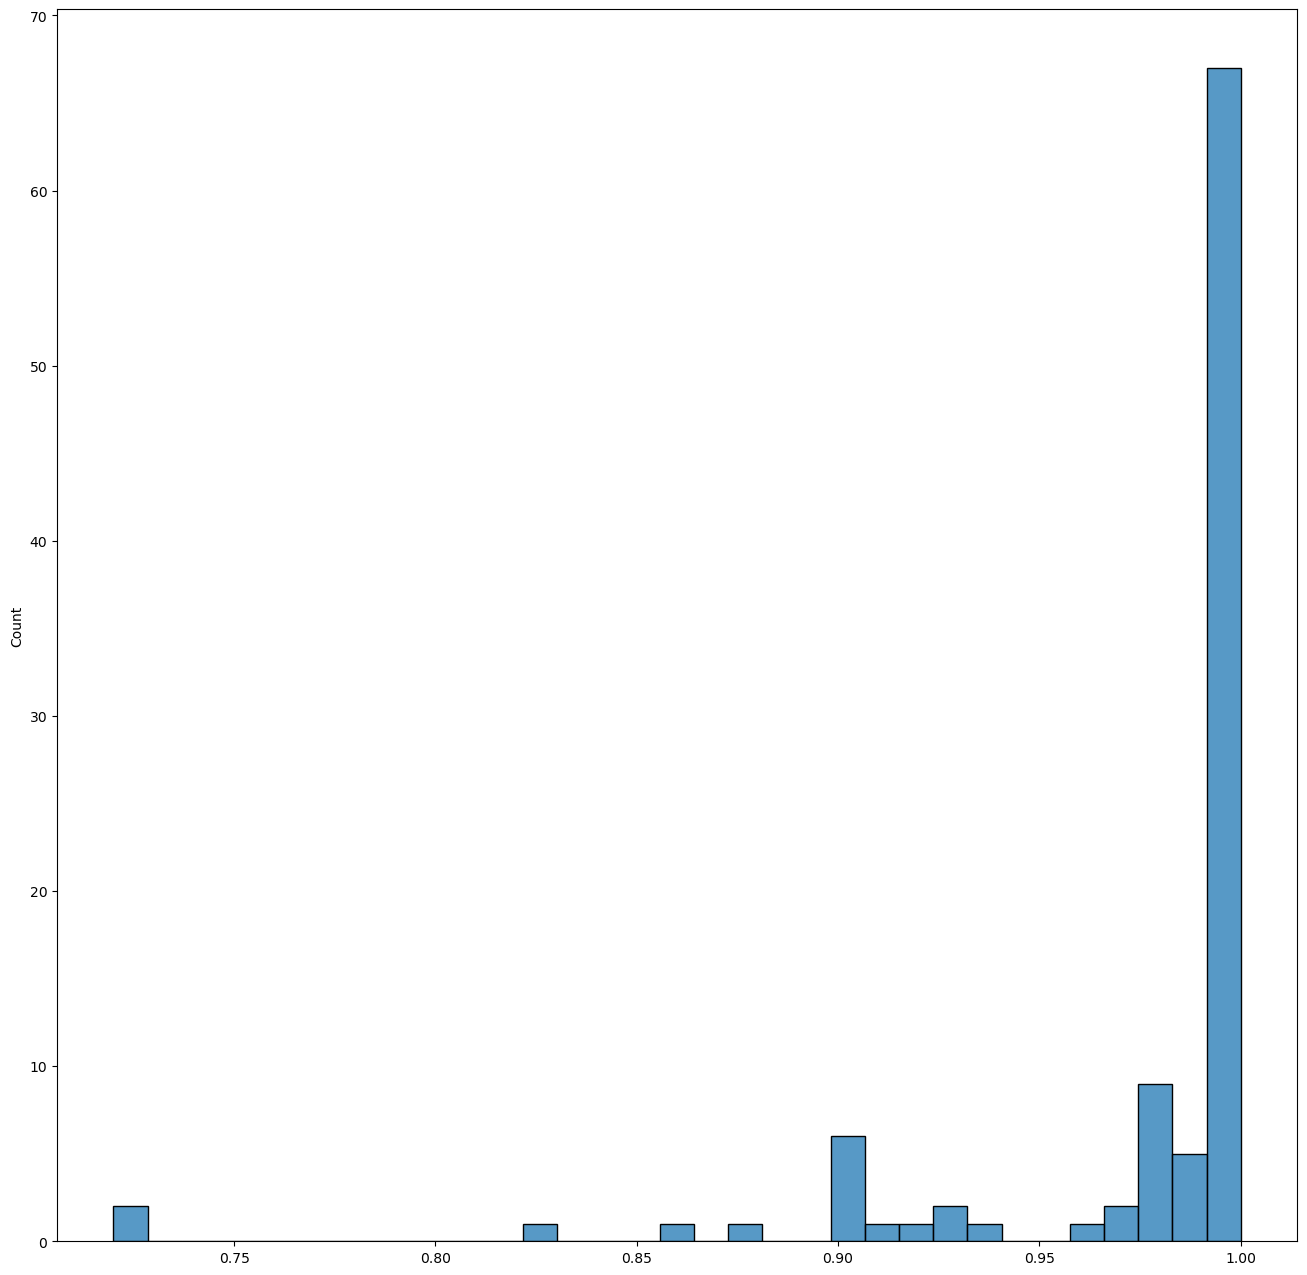

In [90]:
plt.figure(figsize=(16,16))
sns.histplot(lcp_pred)
plt.show()

#### Example User

Say we have a 50 year old male who occasionally smokes and experiences shortness of breath when he does, drinks alcohol a few times a week, regularly feels fatigue, and has no history of chronic lung disease or difficulties with swallowing.  We can type in all the appropriate values for this user for each variable.

In [91]:
#User1 values:
gender = 1
age = 50
smoking = 3
cld = 1
fatigue = 4
alcohol = 5
shortnessBreath = 2
swallowingDiff = 1

The values can be altered where need be (e.g. take the log certain variables) and then plugged into the model and ran.  We see that this user has a score of 0.92.

In [92]:
age_log = np.log(age)
fatigue_log = np.log(fatigue)
shortnessBreath_log = np.log(shortnessBreath)

user1_data = [gender,age_log,smoking,cld,fatigue_log,alcohol,shortnessBreath_log,swallowingDiff]
user1_df = pd.DataFrame(columns=['Gender', 'Age log', 'Smoking', 'chronic Lung Disease', 'Fatigue log', 'Alcohol use', 'Shortness of Breath log', 'Swallowing Difficulty'])
user1_df.loc[0] = user1_data
user1_pred = lcp_model.predict(user1_df)
user1_pred

array([0.92])